# IIVP - Project 1
### 6252320 - Leon Debnath

Import the required modules for the notebook

In [1]:
from sklearn.preprocessing import normalize
from skimage.util import random_noise
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

In [2]:
def display(images, labels, axis='off', cmap=None, figsize=(15,10), cols=2):
    
    if len(images) != len(labels):
        raise Exception("images and labels don't correspond")
        
    fig = plt.figure(figsize=figsize)
    rows = math.ceil(len(images)/cols)
    
    for i in range(len(images)):
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(images[i], cmap=cmap)
        plt.title(labels[i])
        plt.axis(axis)

# Exercise 1 - Image Degradation and Motion Blur

## 1.1 Degrading & Additive Noise

### 1.1.1 - Motion Blurring

A motion blur filter $H$ is created where $H(u,v) = sinc(\alpha \cdot u + \beta \cdot v) \cdot e^{-j\pi(\alpha \cdot u + \beta \cdot v)}$.  The variables $\alpha$ and $\beta$ tune the amount of blur for vertical and horizontal directions respectively.  To blur the image, the colour channels are split and each channel is transformed into the fourier domain seperately, as though a greyscale image.  Then each channel is multiplied by $H(u,v)$ before being returned to the spacial domain.

In [3]:
def blur_channel(c, a, b):
    
    height, width = c.shape
    c_fft = np.fft.fft2(c)
    [u, v] = np.mgrid[-round(height/2):round(height/2), -round(width/2):round(width/2)]
    u = 2 * u / height
    v = 2 * v / width
    h = np.sinc((u*a + v*b)) * np.exp(-1j * np.pi * (u*a + v*b))
    return np.abs(np.fft.ifft2(c_fft * h))


def blur(img, a, b):
    
    (c1, c2, c3) = cv2.split(img)
    c1_ = blur_channel(c1, a, b)
    c2_ = blur_channel(c2, a, b)
    c3_ = blur_channel(c3, a, b)
    img_blurred = cv2.merge((c1_, c2_, c3_))
    return img_blurred / np.max(img_blurred)

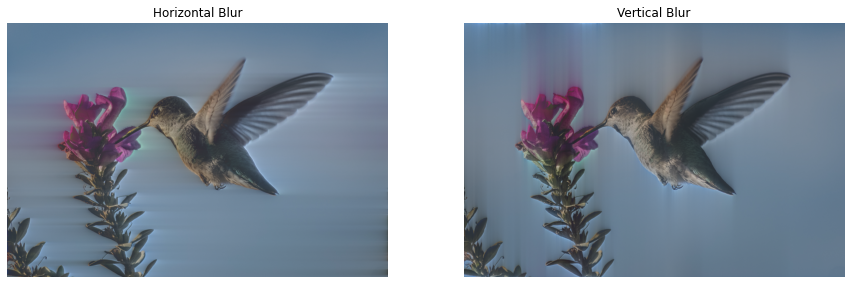

In [4]:
bird = cv2.cvtColor(cv2.imread('images/bird.jpg'), cv2.COLOR_BGR2RGB)
bird = bird/255

bird_blurred_h = blur(bird, 0, 0.15)
bird_blurred_v = blur(bird, 0.15, 0)

display([bird_blurred_h, bird_blurred_v], ['Horizontal Blur', 'Vertical Blur'])

### 1.1.2 - Gaussian Noise

Gaussian noise is added by creating an array the same size as the image full of random numbers that fit the distribution with a $\mu = 0$ and $\sigma = 0.04$.  This array is then summed with the image to create random distortions.  

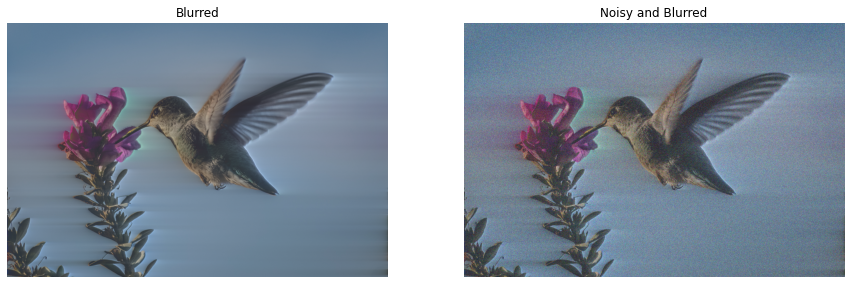

In [5]:
bird_gaussian = random_noise(bird_blurred_h, "gaussian", mean=0, var=0.04)
display([bird_blurred_h, bird_gaussian], ['Blurred', 'Noisy and Blurred'])

### 1.1.3 - Display Images

The final product conception can be observed in the three stages; in it's original form (1), blurred using the horizontal motion blur (2) and with noise added.  This transformation is represented by the formula:

$$
G(u, v) = F(u,v)H(u,v) + N(u,v)
$$

where $F$ is the Fourier Transform, $H$ is the motion blur and $N$ is the gaussian noise

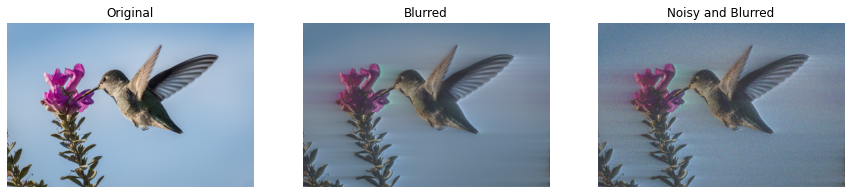

In [6]:
display([bird, bird_blurred_h, bird_gaussian], ['Original', 'Blurred', 'Noisy and Blurred'], cols=3)

## 2.1 - Removing Noise

If $H$ is known, removal of blur is a simple process of transforming to the Fourier domain, dividing the image by $H(u,v)$ and then returning the image back to the spacial domain.  This is represented by the formula:

$$
G(u, v) = \frac{F(u,v)}{H(u,v)}
$$

In [7]:
def inv_blur_channel(c, a, b):
    
    height, width = c.shape
    c_fft = np.fft.fft2(c)    
    [u, v] = np.mgrid[-round(height/2):round(height/2), -round(width/2):round(width/2)]
    u = 2 * u / height
    v = 2 * v / width
    h = np.sinc((u*a + v*b)) * np.exp(-1j * np.pi * (u*a + v*b))
    return np.abs(np.fft.ifft2(c_fft / h))


def inv_blur(img, a, b):
    
    (c1, c2, c3) = cv2.split(img)
    c1_ = inv_blur_channel(c1, a, b)
    c2_ = inv_blur_channel(c2, a, b)
    c3_ = inv_blur_channel(c3, a, b)
    img_blurred = cv2.merge((c1_, c2_, c3_))
    return img_blurred / np.max(img_blurred)

### 2.1.1 - Inverse Blur Filtering

The result of applying the inverse blur is shown below, although it does a good job of removing the blur, the image is clearly not as sharp as the original.

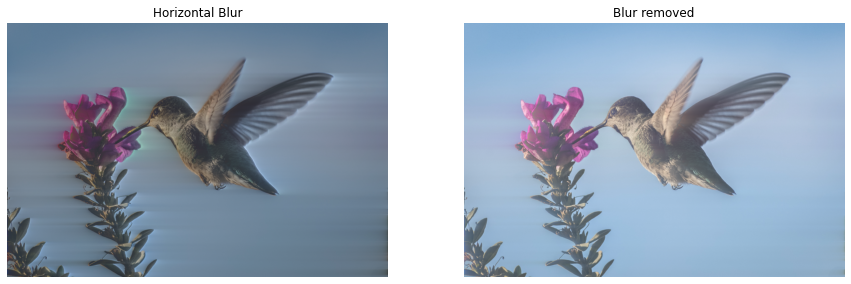

In [8]:
display([bird_blurred_h, inv_blur(bird_blurred_h, 0, 0.15)],['Horizontal Blur', 'Blur removed'])

### 2.1.2 - Inverse Blur Filtering with Noise

When gaussian noise has been applied to the image, the inverse filtering has no effect on the noise.  This is due to the fact that the noise is random and thus cannot be removed by the application of a periodic function.

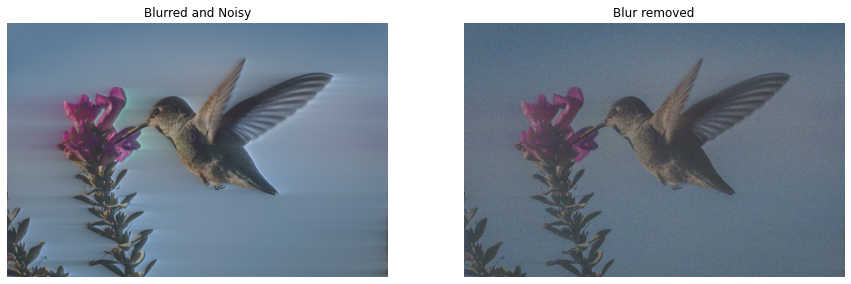

In [9]:
display([bird_blurred_h, inv_blur(bird_gaussian, 0, 0.15)], ['Blurred and Noisy', 'Blur removed'])

### 2.1.3 - MMSE Filter

In [10]:
def mmse_filter_channel(chl_o, chl_n, k_ratio):

    o_fft = np.fft.fftshift(np.fft.fft2(chl_o))
    o_pwr_spectrum = np.abs(o_fft) ** 2
    
    n_fft = np.fft.fftshift(np.fft.fft2(chl_n))
    n_pwr_spectrum = np.abs(n_fft) ** 2
    
    if k_ratio:
        k = np.sum(n_pwr_spectrum) / np.sum(o_pwr_spectrum)
    else:
        k = 1
        
    fft_combined = np.fft.fftshift(np.fft.fft2(chl_o + chl_n)) 
    img_back_fft = fft_combined / (1 + ((n_pwr_spectrum / o_pwr_spectrum) * k))
    img_back = np.fft.ifft2(img_back_fft)
    
    return np.abs(img_back)


def mmse_filter(img_o, img_n, k_ratio=False):
    
    (c1, c2, c3) = cv2.split(img_o)
    (n1, n2, n3) = cv2.split(img_n)
    c1_ = mmse_filter_channel(c1, n1, k_ratio)
    c2_ = mmse_filter_channel(c2, n2, k_ratio)
    c3_ = mmse_filter_channel(c3, n3, k_ratio)
    img = cv2.merge((c1_, c2_, c3_))
    return img / np.max(img)

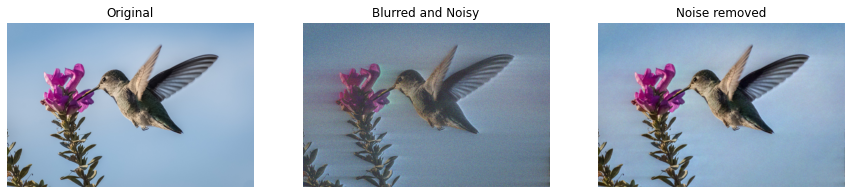

In [11]:
display([bird, bird_gaussian, mmse_filter(bird, bird_gaussian)], ['Original', 'Blurred and Noisy', 'Noise removed'],
       cols=3)

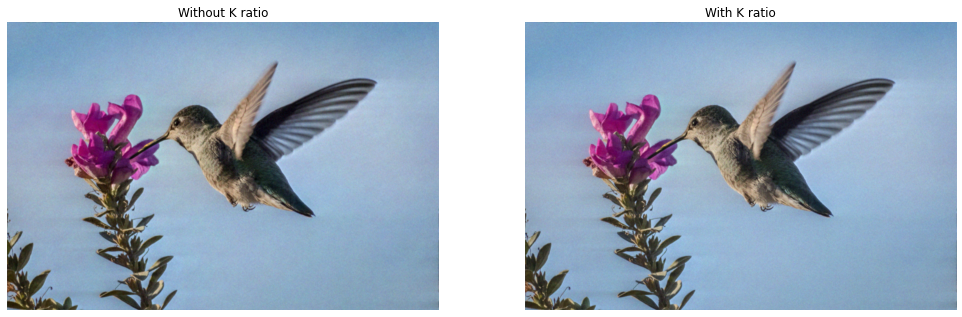

In [12]:
bird_wo_k = mmse_filter(bird, bird_gaussian)
bird_w_k = mmse_filter(bird, bird_gaussian, k_ratio=True)
display([bird_wo_k, bird_w_k],['Without K ratio', 'With K ratio'], figsize=(17,23))

The application of a $K$ ratio shows a slight, if not particularly noticable improvement on the original image, however when the difference for each channel is found between the original image and the MMSE filtered images, a clear difference is apparent, most notably in the blue channel. 

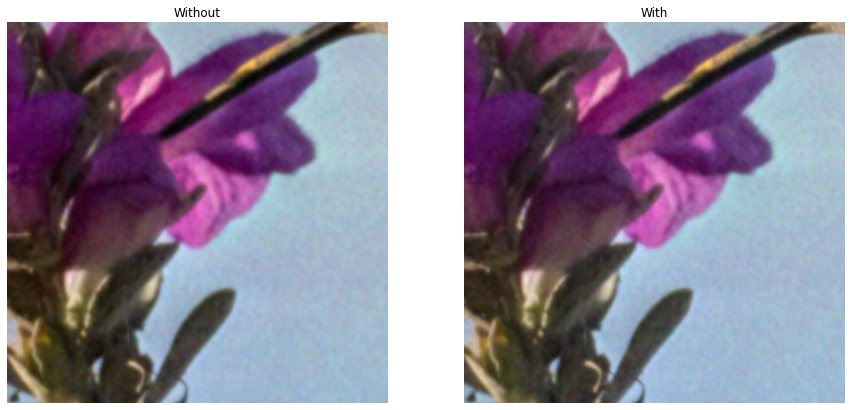

In [13]:
x, y = 800, 650
display([bird_wo_k[x+0:x+500, y+0:y+500], bird_w_k[x+0:x+500, y+0:y+500]], ['Without', 'With'])

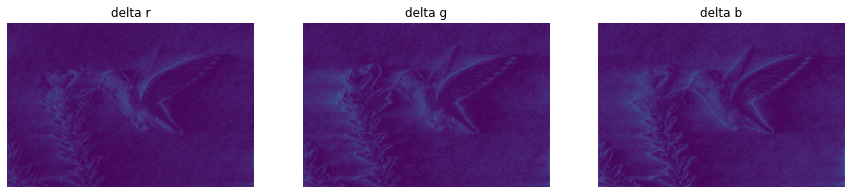

In [14]:
r = np.abs(bird[:, :, 0] - bird_wo_k[:, :, 0])
g = np.abs(bird[:, :, 1] - bird_wo_k[:, :, 1])
b = np.abs(bird[:, :, 2] - bird_wo_k[:, :, 2])
display([r, g, b], ['delta r', 'delta g', 'delta b'], cols=3)

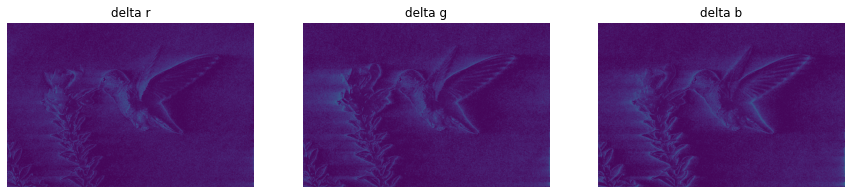

In [15]:
r = np.abs(bird[:, :, 0] - bird_w_k[:, :, 0])
g = np.abs(bird[:, :, 1] - bird_w_k[:, :, 1])
b = np.abs(bird[:, :, 2] - bird_w_k[:, :, 2])
display([r, g, b], ['delta r', 'delta g', 'delta b'], cols=3)

# Exercise 2 - Hide a Secret Message in an Image DCT

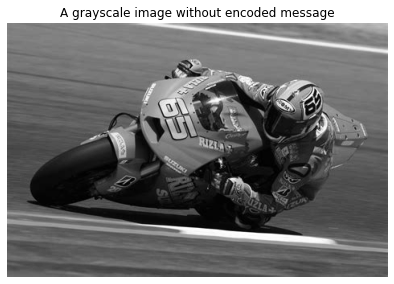

In [16]:
from scipy import fftpack
from numpy import pi
from numpy import r_

bike = cv2.cvtColor(cv2.imread('images/motogp.jpeg'), cv2.COLOR_BGR2GRAY)
display([bike],['A grayscale image without encoded message'], cmap='gray')

## 2.1 Watermark Insertion

Two functions were used to apply a blockwise Discrete Cosine Transform (DCT) to an image with a variable blcok size.  In this case the blocksize of 8 was chosen, returning a 8x8 matrix of coeficients that made up the original image. The top left [0,0] coeficient indicates the value of the DC component (the brightness of the overall block) while every other coeficient holds the value of the contribution of that particular combination of vertical and horizontal cosine waves to the original image, with the lower right [7,7] block showing a checkerbaord pattern that sees a peak of a wave at every other pixel, and a trough at the pixels between peaks.

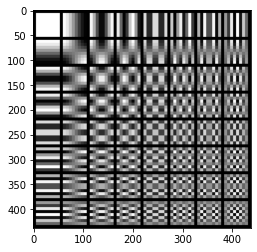

In [17]:
plt.imshow(cv2.cvtColor(cv2.imread('images/DCT-8x8.png'), cv2.COLOR_BGR2RGB));

In [18]:
def dct2(a):
    
    return fftpack.dct( fftpack.dct( a.T, norm='ortho' ).T, norm='ortho' )


def dct(img, block_size=8):
    
    dct = np.zeros(img.shape)

    for i in r_[:img.shape[0]: block_size]:
        for j in r_[:img.shape[1]: block_size]:
            dct[i: i + block_size, j: j + block_size] = dct2(img[i:i+ block_size, j: j+ block_size])
            
    return dct

 A second two functions were used to compute the inverse DCT from an 8x8 coefficent matrix, returning the original values.

In [19]:
def idct2(a):
    
    return fftpack.idct( fftpack.idct( a.T , norm='ortho').T,norm='ortho')        
        
    
def idct(img_dct, block_size=8):
    
    img = np.zeros(img_dct.shape)
    
    for i in r_[:img.shape[0]: block_size]:
        for j in r_[:img.shape[1]: block_size]:
            img[i:(i + block_size), j:(j + block_size)] = idct2( img_dct[i:(i + block_size),j:(j + block_size)])
    
    return img

In [20]:
def apply_threshold(img_dct, threshold):
    
    return img_dct * (abs(img_dct) > (threshold * np.max(img_dct)))
    

In [21]:
def filter_k(block, k):
    """ Return the K (absolute) largest values in the same location as found in the block """
    oput = np.zeros(block.shape)
    block_abs = np.abs(block)
    
    for i in range(k):
        r, c = np.unravel_index(np.argmax(block_abs, axis=None), block_abs.shape)
        oput[r,c] = block[r,c]
        block_abs[r,c] = 0;
        
    return oput
        
    
def filter_k_highest(img_dct, k, block_size=8):
    
    oput = np.zeros(img_dct.shape)
    
    for i in r_[:img_dct.shape[0]: block_size]:
        for j in r_[:img_dct.shape[1]: block_size]:
            oput[i:(i + block_size), j:(j + block_size)] = filter_k(img_dct[i:(i + block_size),j:(j + block_size)], k)
    
    return oput

### 2.1.1 - Compute the 2-D DCT

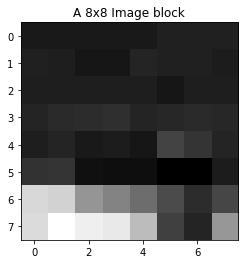

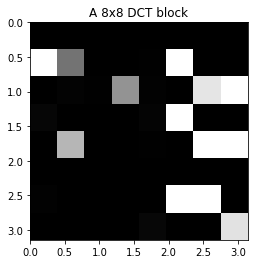

In [22]:
x = 55
y = 275
block_size=8

bike_dct = dct(bike)

# Extract a block from image
plt.figure()
plt.imshow(bike[x: x + block_size, y: y + block_size], cmap='gray')
plt.title(f"A {block_size}x{block_size} Image block")

# Display the dct of that block
plt.figure()
plt.imshow(bike_dct[x: x + block_size, y: y + block_size],
           cmap='gray',
           vmax=np.max(bike_dct) * 0.01,
           vmin=0,
           extent=[0,pi,pi,0])

plt.title(f"A {block_size}x{block_size} DCT block");

Showing the entire image DCT gives an indication of where high frequency block are within the image.  Areas with high density of yellow correspond to areas of change on the motorbike, such as the rider, wheel rims and nose of the bike.  The background, where many parts of the image are almost all one colour, show only the DC component, or a very few low frequency components near the [0,0] position of the matrix.

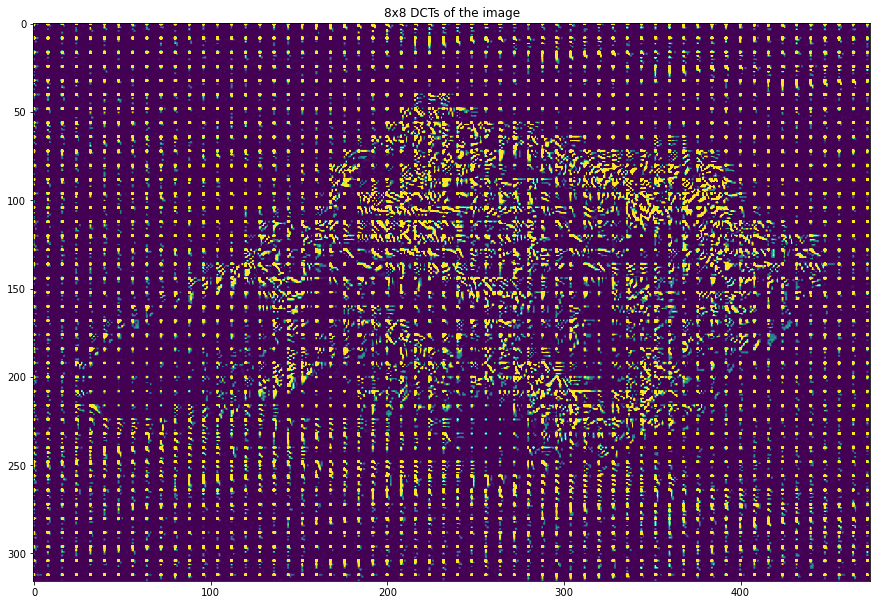

In [23]:
plt.figure(figsize=(15,15))
plt.imshow(bike_dct, vmax = np.max(bike_dct)*0.01, vmin = 0)
plt.title( "8x8 DCTs of the image");

### 2.1.2 - Choose the $K$ Largest Coeficients 

Using a single value threshold allows for an understanding of how much loss occurs within the output image quality relative to the number of values stored.  As the threshold is reduced, the percentage of coeficients reduces rapidly, hoever the plateus in the graph below also indicate points where little to no loss can be achieved while still reducing the number of coefficients (and thus storeage size) of the final image.

In [24]:
x = [x * 0.0005 for x in range(1, 50)]
thresholds = {}
coeficients = {}

for key in x:
    thresholds[key] = apply_threshold(bike_dct, key)
    coeficients[key] = 100 * np.sum(thresholds[key] != 0.0 ) / (bike.shape[0] * bike.shape[1] * 1.0)

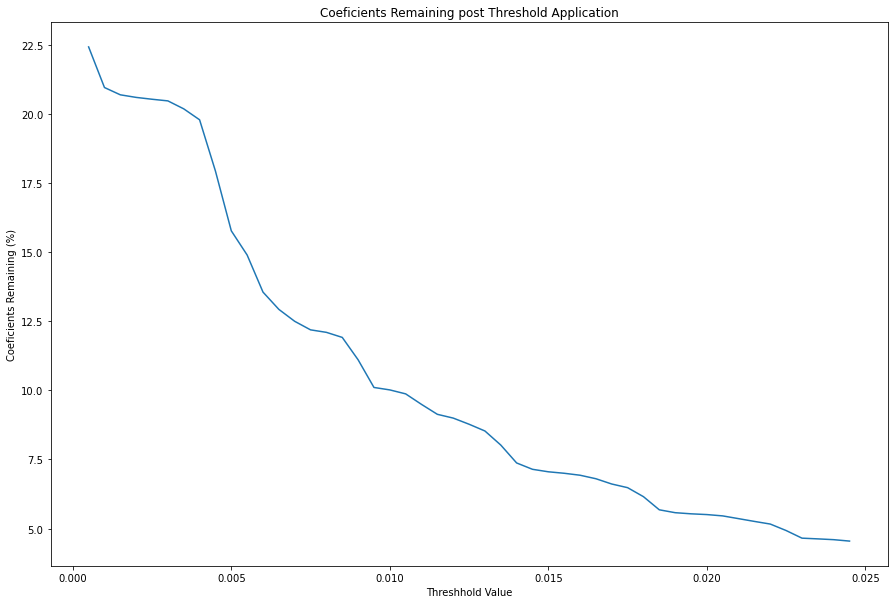

In [25]:
plt.figure(figsize=(15,10))
plt.plot(list(coeficients.keys()), list(coeficients.values()))
plt.title('Coeficients Remaining post Threshold Application')
plt.xlabel('Threshhold Value')
plt.ylabel('Coeficients Remaining (%)');

The images below show the final image after coefficients have been removed at different levels.  Note that, after removing circa 13% of the image's coefficients (a threshold of 0.005) the image has had a negligible reduction in quality to the human eye.  The degredation at higher thresholds (above 0.015) is clear in the high pixellation and visible 8x8 blocks.

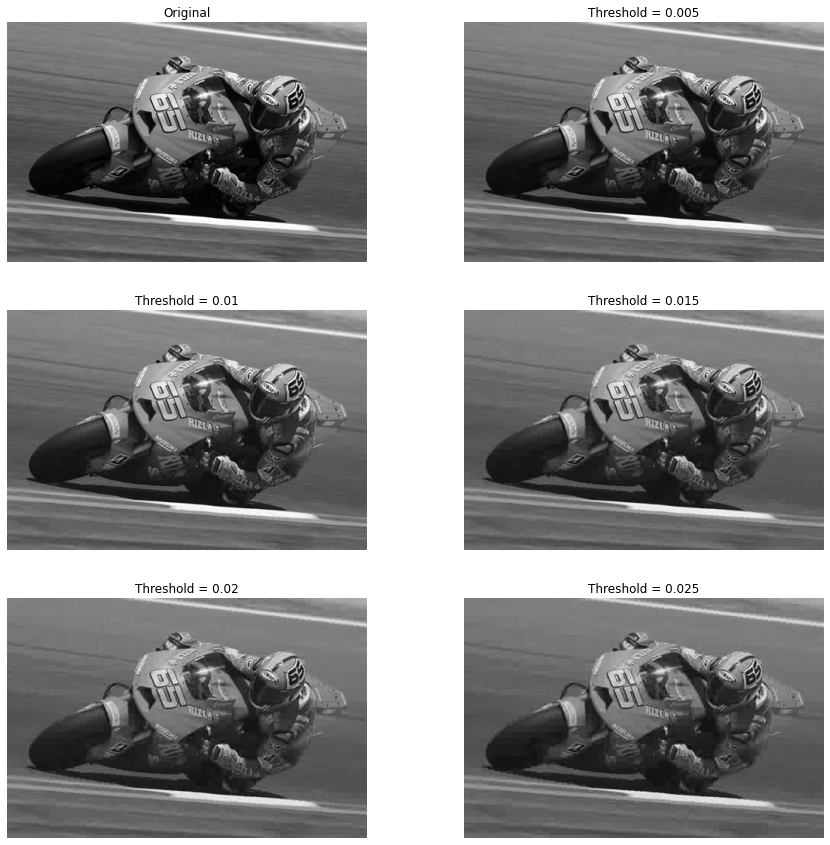

In [26]:
transformed = idct(apply_threshold(bike_dct, 0.001))

display([bike, 
         idct(apply_threshold(bike_dct, 0.005)),
         idct(apply_threshold(bike_dct, 0.01)),
         idct(apply_threshold(bike_dct, 0.015)),
         idct(apply_threshold(bike_dct, 0.02)),
         idct(apply_threshold(bike_dct, 0.025))],
        ['Original',
         'Threshold = 0.005',
         'Threshold = 0.01',
         'Threshold = 0.015',
         'Threshold = 0.02',
         'Threshold = 0.025'],
        figsize=(15,15),
        cmap='gray')

A close up view of one block shows the output before and after the threshold is applied, with the lowest values (in grey) set to zero (shown in black).

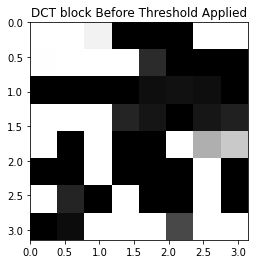

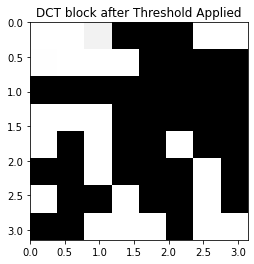

In [27]:
x_pos = 100
y_pos = 200
block_size=8

bike_dct = dct(bike)

# Display the dct of that block
plt.figure()
plt.imshow(bike_dct[x_pos: x_pos + block_size, y_pos: y_pos + block_size],
           cmap='gray',
           vmax=np.max(bike_dct) * 0.01,
           vmin=0,
           extent=[0,pi,pi,0])
plt.title(f"DCT block Before Threshold Applied");

bike_dct_t = apply_threshold(bike_dct, 0.0085)

# Display the dct of that block
plt.figure()
plt.imshow(bike_dct_t[x_pos: x_pos + block_size, y_pos: y_pos + block_size],
           cmap='gray',
           vmax=np.max(bike_dct) * 0.01,
           vmin=0,
           extent=[0,pi,pi,0])

plt.title(f"DCT block after Threshold Applied");

To encode a watermark in the image, the threshold must be set at a certain value per block.  This value was experimentally found by increasing the integer value of coefficients remaining in each block and observing if there was a visible deterioration of the image quality. A value of 32 was selected as a value slightly higher than the human observable "identical" image, due to the fact that some deterioration would be likely while adding the watermark.

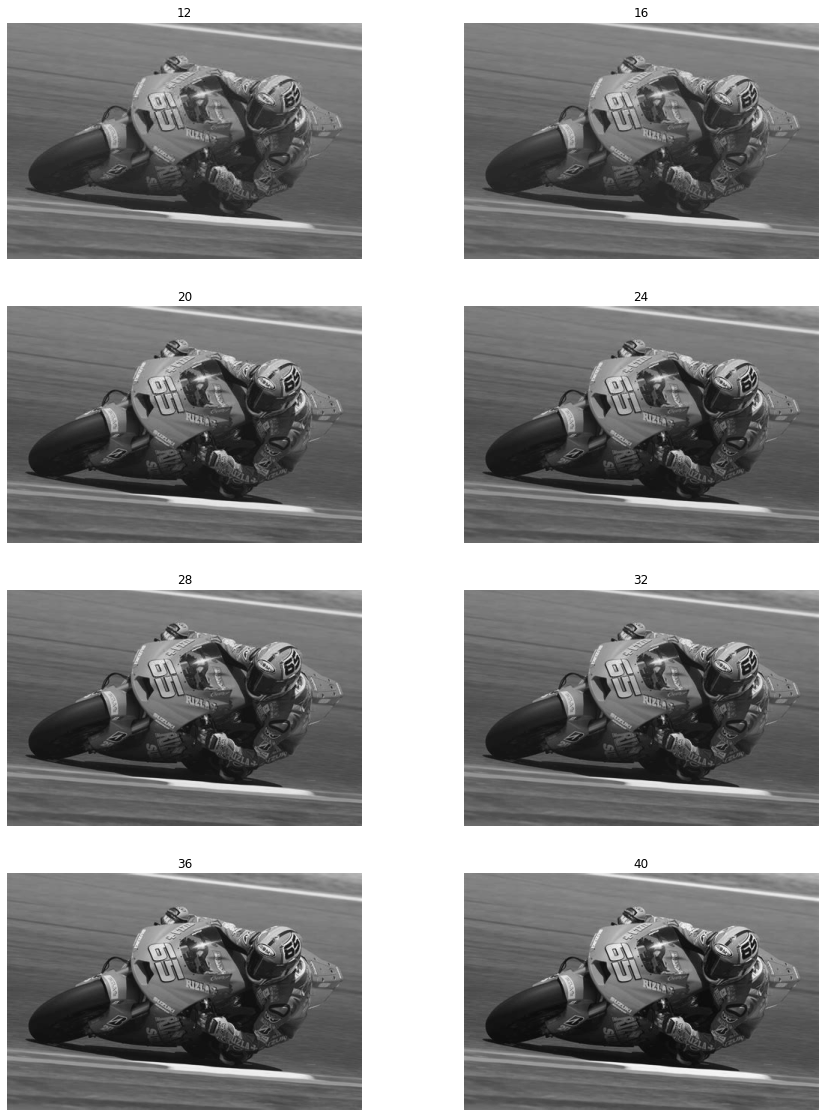

In [28]:
K = [n for n in range(12,42,4)]

images = {}

for k in K:
    images[k] = idct(filter_k_highest(bike_dct, k))
    
values = list(images.values())
keys = list(images.keys())
display(values, keys, cmap='gray', figsize=(15, 20))

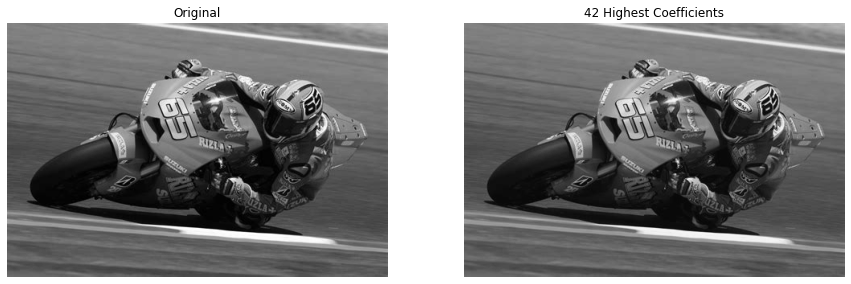

In [29]:
display([bike, idct(filter_k_highest(bike_dct, 42))], ['Original', '42 Highest Coefficients'], cmap='gray')

### 2.1.3 - Create a watermark

The watermark was created using a gaussian distribution of 42 random numbers with a $\mu = 0$ and $\sigma = 0.1$  These values were experimentally found to be low enough not to cause undue noise within the image while still remaining detectable post watermarking.

In [30]:
k = 42
mu = 0
sigma = 1
alpha = 0.1

w = np.random.default_rng().normal(size=(k,))
print(w)

[ 1.35588986  0.59576815 -1.3410713   0.91605149 -2.3372345  -0.53998193
  0.74126438  0.66097563  0.63396177 -1.60287178  1.23790184  0.49792025
  0.09408841 -1.69174789  1.91681592 -0.41824371  0.64510506 -0.72951496
 -1.16018426 -0.70615538  0.48261985 -1.82299708  0.34300261  0.36842329
 -0.57375086  0.35055024 -0.44293726  0.82174163 -0.05326734  0.17072561
 -2.15983821  0.88540035  0.41830177  0.53052315  0.1483902   0.4906415
  0.52743397 -0.67158849  1.23294265 -0.06418687  0.18955346  1.39200908]


### 2.1.4 - Embed a Watermark

In [31]:
def watermark_block(block, w):
    
    oput = np.zeros(block.shape)
    block_abs = np.abs(block)
    
    for w_i in w:
        r, c = np.unravel_index(np.argmax(block_abs, axis=None), block_abs.shape)
        oput[r,c] = block[r,c] * (1 + alpha * w_i)
        block_abs[r,c] = 0;
    
    oput[0,0] = block[0,0]     
    return oput
        
    
def watermark(img_dct, w, block_size=8):
    
    oput = np.zeros(img_dct.shape)
    
    for i in r_[:img_dct.shape[0]: block_size]:
        for j in r_[:img_dct.shape[1]: block_size]:
            oput[i:(i + block_size), j:(j + block_size)] = watermark_block(img_dct[i:(i + block_size),j:(j + block_size)], w)
    
    return oput

### 2.1.5 - Create the Watermarked DCT

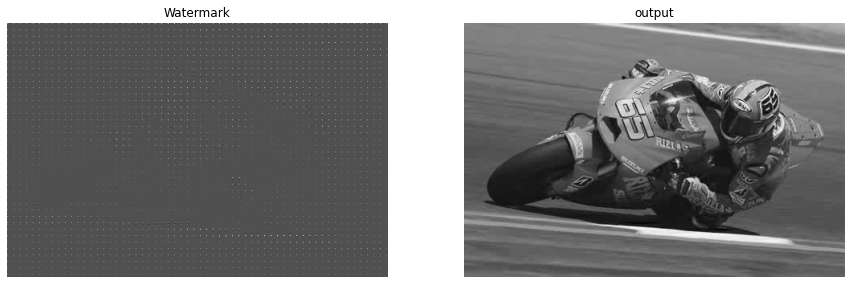

In [32]:
bike_w = watermark(bike_dct_t, w)

display([bike_w, idct(bike_w)],['Watermark', 'output'], cmap='gray')

### 2.1.6 - Comparison

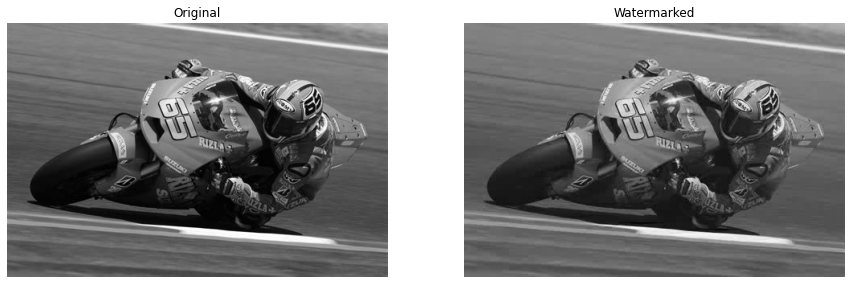

In [33]:
display([bike, idct(bike_w)], ['Original', 'Watermarked'], cmap='gray')

### 2.1.7 - Histogram

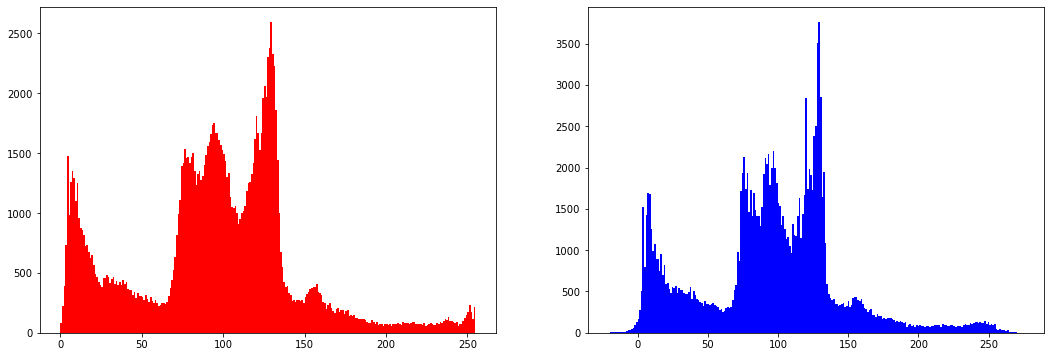

In [34]:
bike_flattened = np.reshape(bike, (bike.shape[0] * bike.shape[1],))
w_flattened = np.reshape(idct(bike_w), (bike_w.shape[0] * bike_w.shape[1],))

fig = plt.figure(figsize=(18,6))
fig.add_subplot(1, 2, 1)
plt.hist(bike_flattened, bins=255, color='red');
fig.add_subplot(1, 2, 2)
plt.hist(w_flattened, bins=255, color='blue');

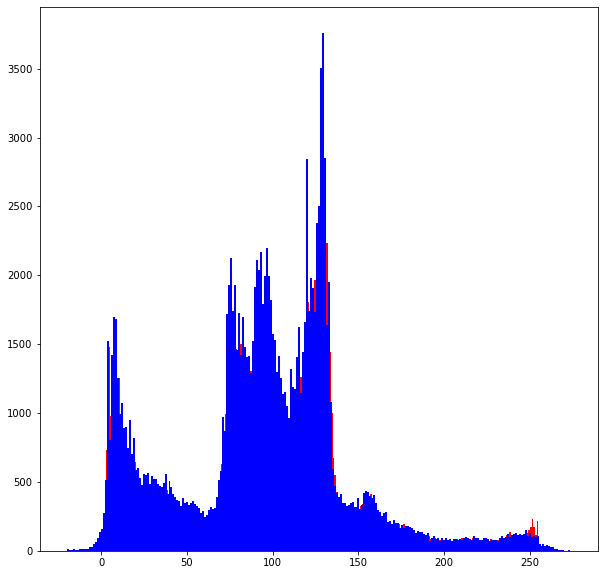

In [35]:
plt.figure(figsize=(10,10))
plt.hist(bike_flattened, bins=255, color='red');
plt.hist(w_flattened, bins=255, color='blue');

### 2.1.8 - DC Coefficient
TODO - Explain

## 2.2 - Watermark Detection

### 2.2.1 - Compute the 2D DCT

In [36]:
mystery_1 = bike
mystery_2 = idct(bike_w)
m1_dct = dct(mystery_1)
m2_dct = dct(mystery_2)

## 2.2.2 - Keep the K largest non-DC coefficients

In [37]:
def remove_DC(img_dct):
    
    oput = img_dct
    
    for i in r_[:img_dct.shape[0]: block_size]:
        for j in r_[:img_dct.shape[1]: block_size]:
            
            oput[i, j] = 0
    
    return oput

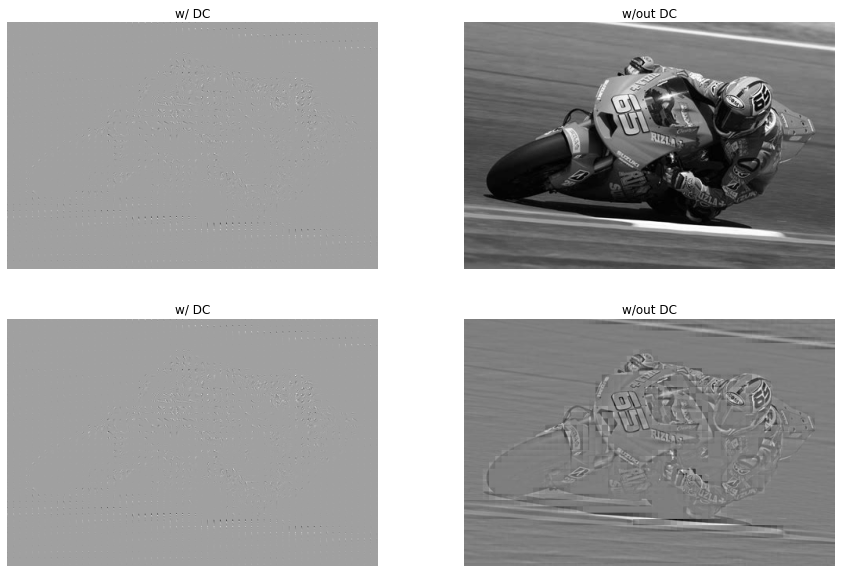

In [38]:
dc_less = remove_DC(m1_dct)
display([m1_dct, mystery_1, dc_less, idct(dc_less)],['w/ DC', 'w/out DC', 'w/ DC', 'w/out DC'], cmap='gray')

In [39]:
m1_dct_filtered = filter_k_highest(m1_dct, k)
m2_dct_filtered = filter_k_highest(m2_dct, k)

In [40]:
def compare_block(c_hat, c, k):
    
    w_hat = []
    c_hat = np.abs(c_hat)
    c_act = np.abs(c)
    
    c_hat[0, 0] = 0
    
    for i in range(k):
        r, c = np.unravel_index(np.argmax(c_hat, axis=None), c_hat.shape)
        
        denom = (alpha * c_act[r, c])
        numer = (c_hat[r, c] - c_act[r, c])
        
        if denom != 0:
            w_hat.append(numer/denom)
        else:
            w_hat.append(0)
                 
        c_hat[r, c] = 0
              
    return w_hat

In [41]:
def estimate_watermark(img_a, img_b, k, block_size=8):
    
    w_hat = []
    
    for i in r_[:img_a.shape[0]: block_size]:
        for j in r_[:img_a.shape[1]: block_size]:
            
            c_hat = img_a[i:(i + block_size),j:(j + block_size)]
            c = img_b[i:(i + block_size),j:(j + block_size)]
            
            w_i = compare_block(c_hat, c, k)
            w_hat.append(w_i)
    
    return np.asarray(w_hat)

In [42]:
w_hats = estimate_watermark(m1_dct_filtered, m2_dct_filtered, k)
print(w_hats.shape)

np.max(w_hats)

(2400, 42)


6.056314010517892e+18

In [43]:
w_hats

array([[-5.62269897e-01,  0.00000000e+00,  4.86579111e+15, ...,
        -1.00000000e+01, -1.00000000e+01, -1.00000000e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.62269897e-01,  9.11440560e+15,  1.44225520e+15, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.00000000e+01, -1.00000000e+01, -1.00000000e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.00000000e+01, -1.00000000e+01, -1.00000000e+01],
       [-5.62269897e-01,  0.00000000e+00,  0.00000000e+00, ...,
        -1.00000000e+01, -1.00000000e+01, -1.00000000e+01]])

In [44]:
w

array([ 1.35588986,  0.59576815, -1.3410713 ,  0.91605149, -2.3372345 ,
       -0.53998193,  0.74126438,  0.66097563,  0.63396177, -1.60287178,
        1.23790184,  0.49792025,  0.09408841, -1.69174789,  1.91681592,
       -0.41824371,  0.64510506, -0.72951496, -1.16018426, -0.70615538,
        0.48261985, -1.82299708,  0.34300261,  0.36842329, -0.57375086,
        0.35055024, -0.44293726,  0.82174163, -0.05326734,  0.17072561,
       -2.15983821,  0.88540035,  0.41830177,  0.53052315,  0.1483902 ,
        0.4906415 ,  0.52743397, -0.67158849,  1.23294265, -0.06418687,
        0.18955346,  1.39200908])

# 3 - Morphology

## 3.1 - Count Oranges

### Pre-processing


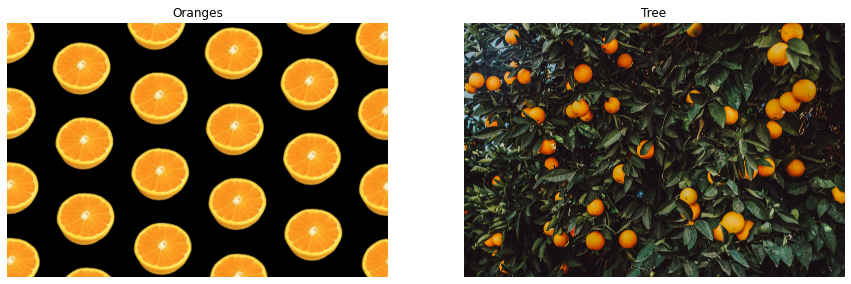

In [45]:
oranges = cv2.cvtColor(cv2.imread('images/oranges.jpg'), cv2.COLOR_BGR2RGB)
tree = cv2.cvtColor(cv2.imread('images/orangetree.jpg'), cv2.COLOR_BGR2RGB)
display([oranges, tree],['Oranges', 'Tree'])

In [46]:
def binary_c(channel, threshold):
    
    thresh, grey = cv2.threshold(channel, threshold, 255, cv2.THRESH_BINARY)
    return grey


def binary(img, t_1, t_2, t_3):
    
    c_1 = binary_c(img[:, :, 0], t_1)
    c_2 = binary_c(img[:, :, 1], t_2)
    c_3 = binary_c(img[:, :, 2], t_3)
    return np.maximum(c_1, c_2, c_3)

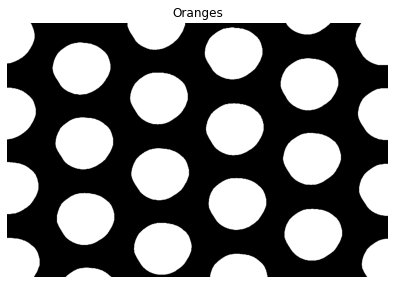

In [47]:
display([binary(oranges, 100, 100, 100)],['Oranges'], cmap='gray')

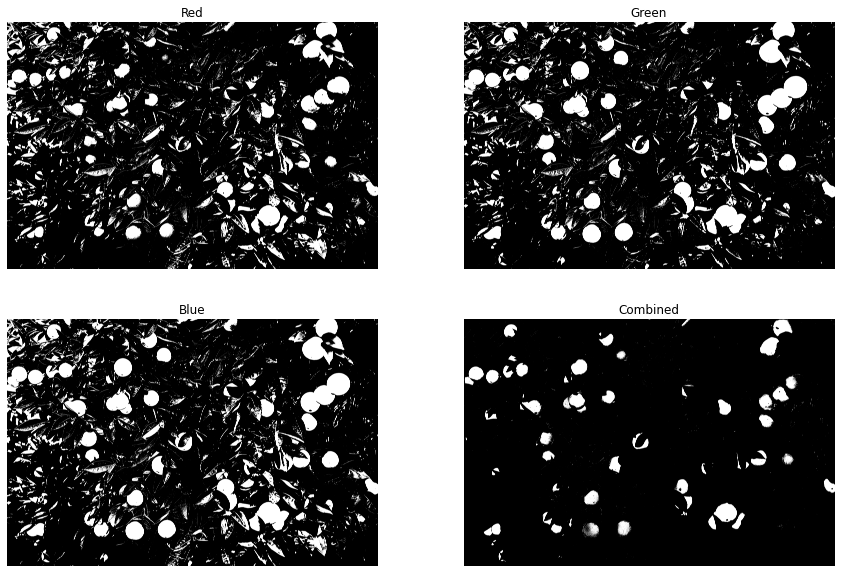

In [48]:
display([binary(tree, 255, 100, 100),
         binary(tree, 100, 255, 100),
         binary(tree, 100, 100, 255),
         binary(tree, 205, 255, 255)],
       ['Red', 'Green', 'Blue', 'Combined'], cmap='gray')

In [49]:
erode = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
dialate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (50, 50))

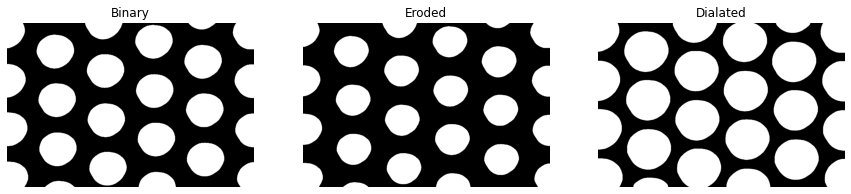

In [50]:
oranges_bin = binary(oranges, 100, 100, 100)
oranges_eroded = cv2.morphologyEx(oranges_bin, cv2.MORPH_ERODE, erode)
oranges_dialated = cv2.morphologyEx(oranges_eroded, cv2.MORPH_DILATE, dialate)

display([oranges_bin, oranges_eroded, oranges_dialated],
        ['Binary', 'Eroded', 'Dialated'], cmap='gray', cols=3)

In [51]:
contours, hierarchy = cv2.findContours(oranges_dialated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print(f"There are {len(contours)} objects in the image")

There are 24 objects in the image


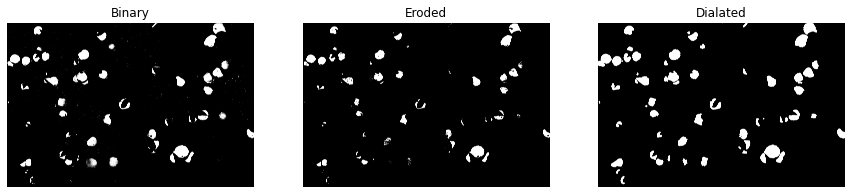

In [52]:
tree_bin = binary(tree, 205, 255, 255)
tree_eroded = cv2.morphologyEx(tree_bin, cv2.MORPH_ERODE, erode)
tree_dialated = cv2.morphologyEx(tree_eroded, cv2.MORPH_DILATE, dialate)

display([tree_bin, tree_eroded, tree_dialated],
        ['Binary', 'Eroded', 'Dialated'], cmap='gray', cols=3)

In [53]:
contours, hierarchy = cv2.findContours(tree_dialated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print(f"There are {len(contours)} objects in the image")

There are 60 objects in the image


## 3.2 - Granulometry

### 3.2.1 - Pre-processing

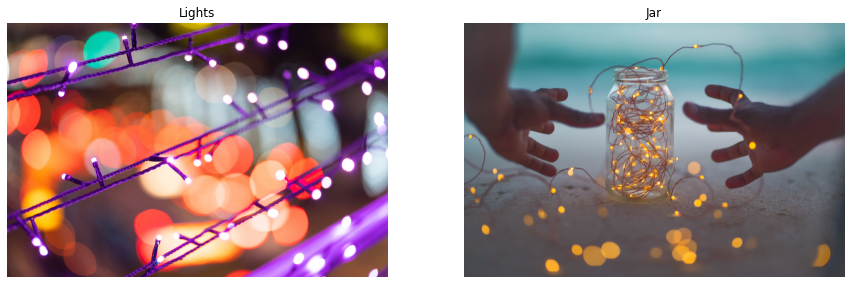

In [54]:
lights = cv2.cvtColor(cv2.imread('images/lights.jpg'), cv2.COLOR_BGR2RGB)
jar = cv2.cvtColor(cv2.imread('images/jar.jpg'), cv2.COLOR_BGR2RGB)
display([lights, jar],['Lights', 'Jar'])

In [55]:
lights_g = cv2.cvtColor(lights, cv2.COLOR_BGR2GRAY)
jar_g = cv2.cvtColor(jar, cv2.COLOR_BGR2GRAY)

In [56]:
sum(sum(lights_g))

764937

In [57]:
np.sum(lights_g[0])

365357

In [58]:
def granulometry(img, d_start, factor, iterations):

    retval = []
    sa = sum(sum(img))
    diameters = [d_start + (d * factor) for d in range(iterations)]
    
    for d in diameters:
        erode = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (d, d))
        dialate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (d, d))
        
        opening = cv2.morphologyEx(img, cv2.MORPH_ERODE, erode)
        opening = cv2.morphologyEx(opening, cv2.MORPH_DILATE, dialate)
        img = opening
        
        new_sa = sum(sum(img))
        retval.append([d / 2, abs(sa - new_sa)])
        sa = new_sa
        
    
    return opening, np.asarray(retval)

In [59]:
lights_hc, lights_fq = granulometry(lights_g, 10, 5, 30)

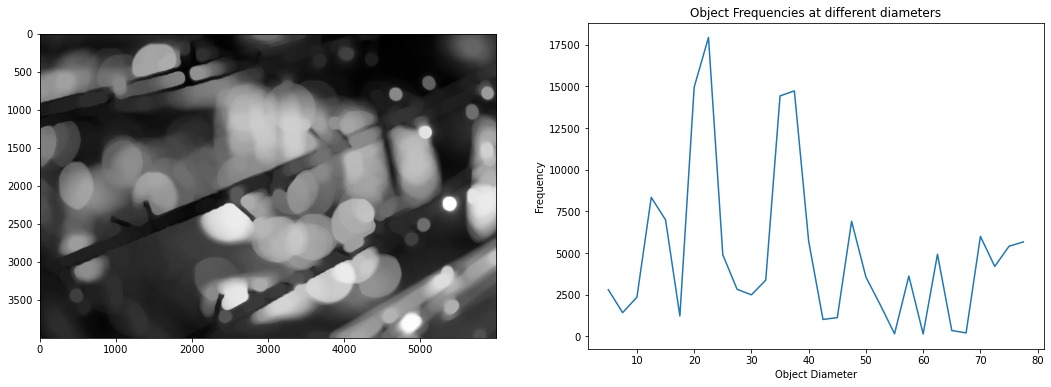

In [60]:
fig = plt.figure(figsize=(18,6))
fig.add_subplot(1, 2, 1)
plt.imshow(lights_hc, cmap='gray');

fig.add_subplot(1, 2, 2)
plt.plot(lights_fq[:,0], lights_fq[:,1])
plt.title('Object Frequencies at different diameters')
plt.xlabel('Object Diameter')
plt.ylabel('Frequency');

In [ ]:
jar_hc, jar_fq = granulometry(jar_g, 10, 5, 30)

In [ ]:
fig = plt.figure(figsize=(18,6))
fig.add_subplot(1, 2, 1)
plt.imshow(jar_hc, cmap='gray');

fig.add_subplot(1, 2, 2)
plt.plot(jar_fq[:,0], jar_fq[:,1])
plt.title('Object Frequencies at different diameters')
plt.xlabel('Object Diameter')
plt.ylabel('Frequency');

# 4 - Principal Component Analysis Recognition

## 4.1 - Eigenfaces

The following steps should be taken to conduct principle component analysis:

1. Format the data into a matrix of points where each is a vector [x, y, z] (M_data)

2. Calculate the Mean vector  (x_mean)

3. Subtract Mean from data matrix  (M = M_data - x_mean)

4. Calculate the Covariance matrix  (C = M * M ^T)

5. Calculate the Eigen vectors and Eigen values of the covariance matrix

The steps have been outlined below in code, however they have been repeated using the cv2 inbuilt function due to the size of the image.

In [ ]:
import glob

faces = []

for filename in glob.glob('faces_aligned/face2*.jpeg'):
    faces.append(cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB))

height, width, channels = faces[0].shape

print(f"Images have dimensions:  height = {height}px , width = {width}px, channels = {channels}")
display(faces, [i for i in range(len(faces))], cols=4)

In [ ]:
# 1. Format the data into a matrix of points where each image is a vector of m * n (900 * 600)   
lst = []

for face in faces:
    m, n, c = face.shape
    lst.append(np.reshape(face, m * n * c))
    
M_data = np.stack(lst, axis=0)
M_data = M_data / 255


# 2. Calculate the Mean vectors
mean = np.mean(M_data, axis=0)


# 3. Subtract Mean from data matrix  (M = M_data - x_mean)
M_data = np.subtract(M_data, mean)
M_data.shape


# 4. Calculate the Covariance matrix  (C = M * M ^T)
C = np.dot(M_data, M_data.T)

# 5. Calculate the Eigen vectors and Eigen values of the covariance matrix
m, eigen_vectors = np.linalg.eig(C)

In [ ]:
m, eigen_vectors = cv2.PCACompute(M_data, mean=None, maxComponents=10)

print(f"Mean vector shape: {mean.shape}")
print(f"Mean vector max: {np.max(mean)}")
print(f"Mean vector min: {np.min(mean)}\n")

print(f"Eigen Vectors shape: {eigen_vectors.shape}")
print(f"Eigen Vectors max: {np.max(eigen_vectors)}")
print(f"Eigen Vectors min: {np.min(eigen_vectors)}\n")
print(eigen_vectors)

### 4.1 - Show the resulting eigenfaces and explain their apperance

The eigen faces, giving the difference between the mean face and the face they represent show very small values.  When normalised to the maximum value it is clear that each eigenface shows a combination of differences between the mean and the image they represent.

In [ ]:
# Reshape EigenVectors to obtain EigenFaces
eig_faces = [np.reshape(e, (height, width, channels)) for e in eigen_vectors]

print(f"There are {len(eig_faces)} eigen faces")

display([ np.abs(f) / np.max(f) for f in eig_faces], [i+1 for i in range(len(faces))], cols=4)

In [ ]:
mean_face = np.reshape(mean, (height, width, channels))

display([mean_face],['Mean Face'], figsize=(10,15))

In [ ]:
def pca(images):
    # 1. Stack images into a matrix2
    lst = []

    for img in images:
        m, n, c = img.shape
        lst.append(np.reshape(img, m * n * c))

    data = np.stack(lst, axis=0)
    data = data / 255
    
    # 2. Calculate the Mean vectors
    mean = np.mean(data, axis=0)
    
    # 3. Subtract Mean from data matrix  (M = M_data - x_mean)
    data = np.subtract(data, mean)
    
    # 4. Calculate the Eigen vectors and Eigen values
    m, eigen_vectors = cv2.PCACompute(data, mean=None, maxComponents=10)
        
    # 5. Reshape mean face back to image
    mean_face = np.reshape(mean, (height, width, channels))
    
    eig_faces = [np.reshape(e, (height, width, channels)) for e in eigen_vectors]
    
    return mean_face, eig_faces

In [ ]:
images = []
for filename in glob.glob('faces_aligned/*.jpeg'):
    images.append(cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB))

display(images, [i for i in range(len(images))], cols=5)

In [ ]:
mean_face, eig_faces = pca(images) 

display([mean_face], ['mean'])

### 4.2.1 - Reconstruct Faces with all Eigenfaces

In [ ]:
output = mean_face

weights = [0 for i in range(len(eig_faces))]
weights[0] = 255
weights[1] = 255
weights[2] = 255
weights[3] = 255


for i, weight in enumerate(weights):
    output = np.add(output, np.multiply(eig_faces[i], weight))

display([output],['Reconstructed Face'], figsize=(10,15))

### 4.2.2 - Reconstruct Faces with few Eigenfaces

In [ ]:
output = mean_face

weights = [0 for i in range(len(eig_faces))]
weights[0] = 255
weights[1] = 255
weights[2] = 0
weights[3] = 0


for i, weight in enumerate(weights):
    output = np.add(output, np.multiply(eig_faces[i], weight))

display([output],['Reconstructed Face'], figsize=(10,15))